# Predicting Tritium Thermo-Desorption Spectra

___

### Context

Tritium is an isotope of Hydrogen used as a fuel in fusion research. In testing, the reactor walls are bombarded by tritium isotopes, which enter the metal lattice through difussion. Regions of the atomic lattice called "trapping sites" retain tritium atoms.

When the reactor wall is removed, the trapped tritium is a huge threat. It will slowly escape the material, and persist in the atmospehre irradiating anything nearby. The estimated cost of decomissioning tritiated metal is $5,000,000 per gram of tritium. 



### Thermal-Desorption Spectrometry

When tritiated metal is heated, the tritium can escape the trapping sides and diffuse out of the metal. This process is called desorption and it's measured using Thermal-Desorption Spectrometry. The amount of tritium released can be modeled as a function of temperature. 

*** 

### ML Challenge 

The computer simulations used to model tritium desorption spectra are computationaly expensive. This means we want to use `twinLab` emulators to predict the Thermal-Desorption Spectra at new inputs to inform design choices under uncertainty.


***

### Imports

In [1]:
# Project imports
import twinlab as tl
from fusion_energy.plot import plot_test, style_axes

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


          ====== TwinLab Client Initialisation ======
          Version     : 2.9.0
          Server      : https://twinlab.digilab.co.uk
          Environment : /Users/joe/repos/FusionEnergy/.env



***

### Downloading Data

The Thermal-Desorption Spectra data is available to you on the `twinLab` cloud as an example dataset. 

In [2]:
data = tl.load_example_dataset('tritium-desorption')

***

### Inputs

The 5 simulation inputs are properties of the wall material describing the trapping of tritium isotopes:

- $E_i$ - the detrapping energies of tritium trap sites in $eV$. 
- $n_i$ - the densities of the trapping sites.


In [3]:
inputs = data.columns[:5].to_list()
data[inputs][:3]

,E1,E2,E3,n1,n2
0,0.726163,1.248766,1.128671,0.002004,0.000307
1,0.787837,0.925174,1.226117,0.001564,0.000768
2,0.710103,0.902457,1.558539,0.004860,0.000613


___

### Outputs

Every simulation outputs n many the tritium desorption rates $D_n$ as the temperature $T$ is increased from 300K to 800K. In our case n = 624 which means there are 624 desroption rates and 624 temperature values.


___

In [4]:
outputs = [f"D{n}" for n in range(624)]

In [5]:
temperatures = pd.DataFrame(np.linspace(300, 800, len(outputs))).T
temperatures.columns = [f"T{n}" for n in range(len(outputs))]
temperatures

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T614,T615,T616,T617,T618,T619,T620,T621,T622,T623
0,300.0,300.802568,301.605136,302.407705,303.210273,304.012841,304.815409,305.617978,306.420546,307.223114,...,792.776886,793.579454,794.382022,795.184591,795.987159,796.789727,797.592295,798.394864,799.197432,800.0


In [6]:
data.columns = list(data.columns[:5]) + outputs

In [7]:
data[outputs]
# data[outputs][:3]

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D614,D615,D616,D617,D618,D619,D620,D621,D622,D623
0,1.511613e+17,1.626357e+17,1.749599e+17,1.881609e+17,2.022474e+17,2.171753e+17,2.329431e+17,2.501679e+17,2.681171e+17,2.873808e+17,...,2.318606e+17,2.304607e+17,2.290609e+17,2.276611e+17,2.262613e+17,2.248615e+17,2.234616e+17,2.220618e+17,2.206620e+17,2.192622e+17
1,7.621430e+16,8.255297e+16,8.942421e+16,9.684174e+16,1.048160e+17,1.133235e+17,1.223659e+17,1.323483e+17,1.428036e+17,1.541191e+17,...,2.728998e+16,2.706896e+16,2.684793e+16,2.662690e+16,2.640587e+16,2.618484e+16,2.596381e+16,2.574279e+16,2.552176e+16,2.530073e+16
2,2.376907e+17,2.553641e+17,2.743015e+17,2.945655e+17,3.161688e+17,3.390432e+17,3.631858e+17,3.895231e+17,4.169486e+17,4.463476e+17,...,2.079730e+16,2.078486e+16,2.077242e+16,2.075998e+16,2.074754e+16,2.073510e+16,2.072265e+16,2.071021e+16,2.069777e+16,2.068533e+16
3,1.491269e+17,1.609964e+17,1.737868e+17,1.875378e+17,2.022633e+17,2.179179e+17,2.345022e+17,2.527081e+17,2.717244e+17,2.922129e+17,...,2.405455e+17,2.382445e+17,2.359435e+17,2.336425e+17,2.313415e+17,2.290405e+17,2.267395e+17,2.244385e+17,2.221375e+17,2.198365e+17
4,8.396414e+15,9.173453e+15,1.003567e+16,1.097871e+16,1.200347e+16,1.310722e+16,1.429071e+16,1.561696e+16,1.701622e+16,1.854882e+16,...,3.434468e+16,3.408240e+16,3.382012e+16,3.355785e+16,3.329557e+16,3.303329e+16,3.277101e+16,3.250873e+16,3.224646e+16,3.198418e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.345699e+17,1.456865e+17,1.576992e+17,1.706529e+17,1.845647e+17,1.993929e+17,2.151391e+17,2.324948e+17,2.506581e+17,2.702898e+17,...,2.099361e+17,2.070631e+17,2.041900e+17,2.013170e+17,1.984440e+17,1.955710e+17,1.926980e+17,1.898249e+17,1.869519e+17,1.840789e+17
396,5.668893e+15,6.290050e+15,6.911207e+15,7.596330e+15,8.344831e+15,9.155117e+15,1.002414e+16,1.100911e+16,1.205281e+16,1.319717e+16,...,1.136794e+17,1.125222e+17,1.113649e+17,1.102076e+17,1.090504e+17,1.078931e+17,1.067358e+17,1.055786e+17,1.044213e+17,1.032640e+17
397,2.624759e+16,2.862085e+16,3.122200e+16,3.405309e+16,3.712017e+16,4.041519e+16,4.394000e+16,4.787436e+16,5.201741e+16,5.654131e+16,...,4.119450e+16,4.079302e+16,4.039155e+16,3.999007e+16,3.958860e+16,3.918712e+16,3.878565e+16,3.838417e+16,3.798270e+16,3.758122e+16
398,5.259842e+15,5.754444e+15,6.307820e+15,6.915794e+15,7.578222e+15,8.293217e+15,9.061298e+15,9.924840e+15,1.083738e+16,1.183949e+16,...,2.415848e+17,2.377526e+17,2.339204e+17,2.300882e+17,2.262560e+17,2.224238e+17,2.185916e+17,2.147594e+17,2.109272e+17,2.072690e+17


***

### Uploading data

We'll create a copy of the example dataset in the `twinLab` cloud to work with.

In [8]:
dataset = tl.Dataset("tritium_desorption")
dataset.upload(data, verbose = False)

***

### Workflow



### Dimensionality reduction

Our dataset has 624 outputs or ***dimensions***, which makes our problem complicated. Luckily we can make it simpler using `twinLab`. 

`twinLab` can learn to reperesent our outputs in fewer dimensions. This makes training and evaluating our emulator faster and cheaper. `twinLab` then reconstructs the more complex outputs when you need them, and you won't be able to tell the difference.

To check if this will work for our problem, we need to:

1. See how well our data can be represented using fewer dimensions.
2. Select a sensible number of dimensions to use.

We can do this using the `analyse_variance` function of our `twinLab` dataset, which tells us how well we can represent our original data using a given number of dimensions.

In [9]:
variance = dataset.analyse_variance(outputs)[1:11]
variance

,Number of Dimensions,Cumulative Variance
1,1,0.265579
2,2,0.734992
3,3,0.895238
4,4,0.969070
5,5,0.989724
6,6,0.996053
7,7,0.998313
8,8,0.999210
9,9,0.999563
10,10,0.999722


In [10]:
number_dimensions = variance['Number of Dimensions'][1:11]
cumulative_variance = variance['Cumulative Variance'][1:10]

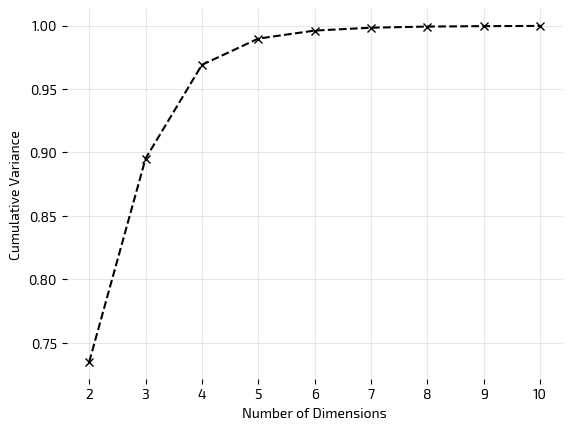

In [11]:
plt.plot(number_dimensions, cumulative_variance, 'kx--')
plt.ylabel("Cumulative Variance")
plt.xlabel("Number of Dimensions")
style_axes(plt.gca())
plt.show()


*** 

### Emulation

Our emulator will use an input $(E_1, E_2, E_3, n_1, n_2)$ to predict the desorption rate and the uncertainty at every temperature. This is a functional emulator because each input corrasponds to the output of a function.

Before we can start training, we will set aside 20% of our data to test our emulator. This data won't be used in training and will be used to check how our emulator performs on "new" data.

<!-- We will use a `single_task_gp` estimator, because ...
 how the emulator performs on new inputs.
 -->

To get started we will:
1. Create an emulator on the `twinlab` cloud.

In [12]:
emulator = tl.Emulator('tritium_desorption') 

2. Set our training parameters.

In [13]:
train_test_ratio = 0.8
output_retained_dimensions = 8
# estimator_params = tl.EstimatorParams(covar_module='M32', estimator_type='single_task_gp')

In [14]:
train_params = tl.TrainParams(
    train_test_ratio = train_test_ratio,
    output_retained_dimensions = output_retained_dimensions,
    # estimator_params = estimator_params,
    seed = 42
)

3. Start!

In [15]:
emulator.train(dataset, inputs, outputs, train_params, verbose = True)

Model tritium_desorption has begun training.
Emulator tritium_desorption with process ID train-zippy-proximal-sparrow is training.
Training status: Your job is currently being uploaded to twinlab-cloud.
Training status: Your job is currently being uploaded to twinlab-cloud.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processe

### Score

Now the emulator is trained, we can use `emulator.score` to see how well it performs.
We're going to use the Root Mean Squared Error (MSE) metric.

In [16]:
rmse = np.sqrt(emulator.score(tl.ScoreParams(metric = 'RMSE', combined_score = True)))
print(f"RMSE  = {rmse:.3e}")

RMSE  = 2.605e+08


In [17]:
test_data = emulator.view_test_data()

In [18]:
mean, std = emulator.predict(test_data[inputs], verbose=False)

*** 

### Test the emulator 

In [19]:
i = np.random.randint(0, test_data.shape[0])

78

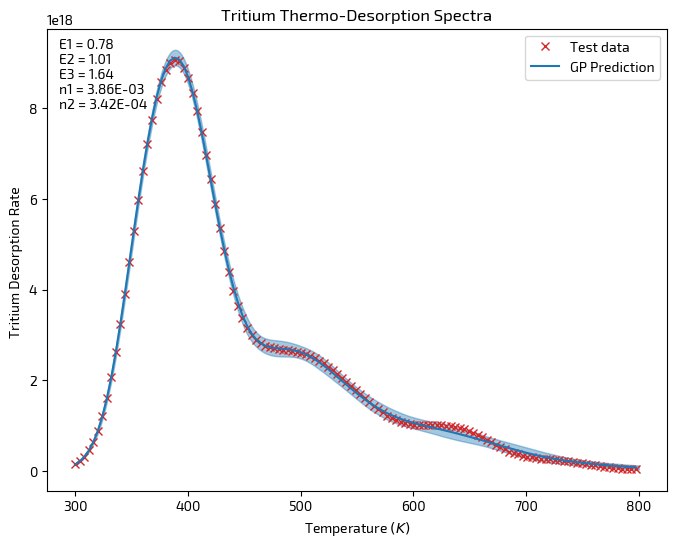

In [22]:
plot_test(i, test_data, mean, std, temperatures)
plt.show()

### Calibration

# Load the streamlit App

In [21]:
%%capture
# !streamlit run app.py